# Imports

In [1]:
%%capture
!pip install keras
!pip install tensorflow

In [2]:
import keras
import tensorflow
from keras import layers
from sklearn.datasets import load_breast_cancer 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Importing Wisconsin Breast Cancer Dataset from sklearn

In [3]:
data = load_breast_cancer()
print(data.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


In [4]:
X = data.data
y = data.target

# Creating two dataframes (features and respective targets) for EDA

In [5]:
features = pd.DataFrame(X, columns = data.feature_names)
targets = pd.DataFrame(y, columns = ['target'])

In [6]:
features.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [7]:
#features.head().T
#targets.isnull().sum()
#targets.value_counts()
#features.info()

In [8]:
count_m = targets[targets['target'] == 1].shape[0]
count_b = targets[targets['target'] == 0].shape[0]

percentage_m = (count_m/targets.shape[0]) * 100
percentage_b = (count_b/targets.shape[0]) * 100

In [9]:
#for column in features.columns:
    #plt.figure()
    #sns.histplot(features[column], kde=True, color='skyblue')
    #plt.title(f'Distribution of {column}', fontsize=16)
    #plt.xlabel('Value', fontsize=14)
    #plt.ylabel('Frequency', fontsize=14)
    #plt.grid(True)
    #plt.show()

# EDA

In [10]:
features.shape

(569, 30)

c:\Users\CarolinaSoria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\CarolinaSoria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\CarolinaSoria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\CarolinaSoria\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

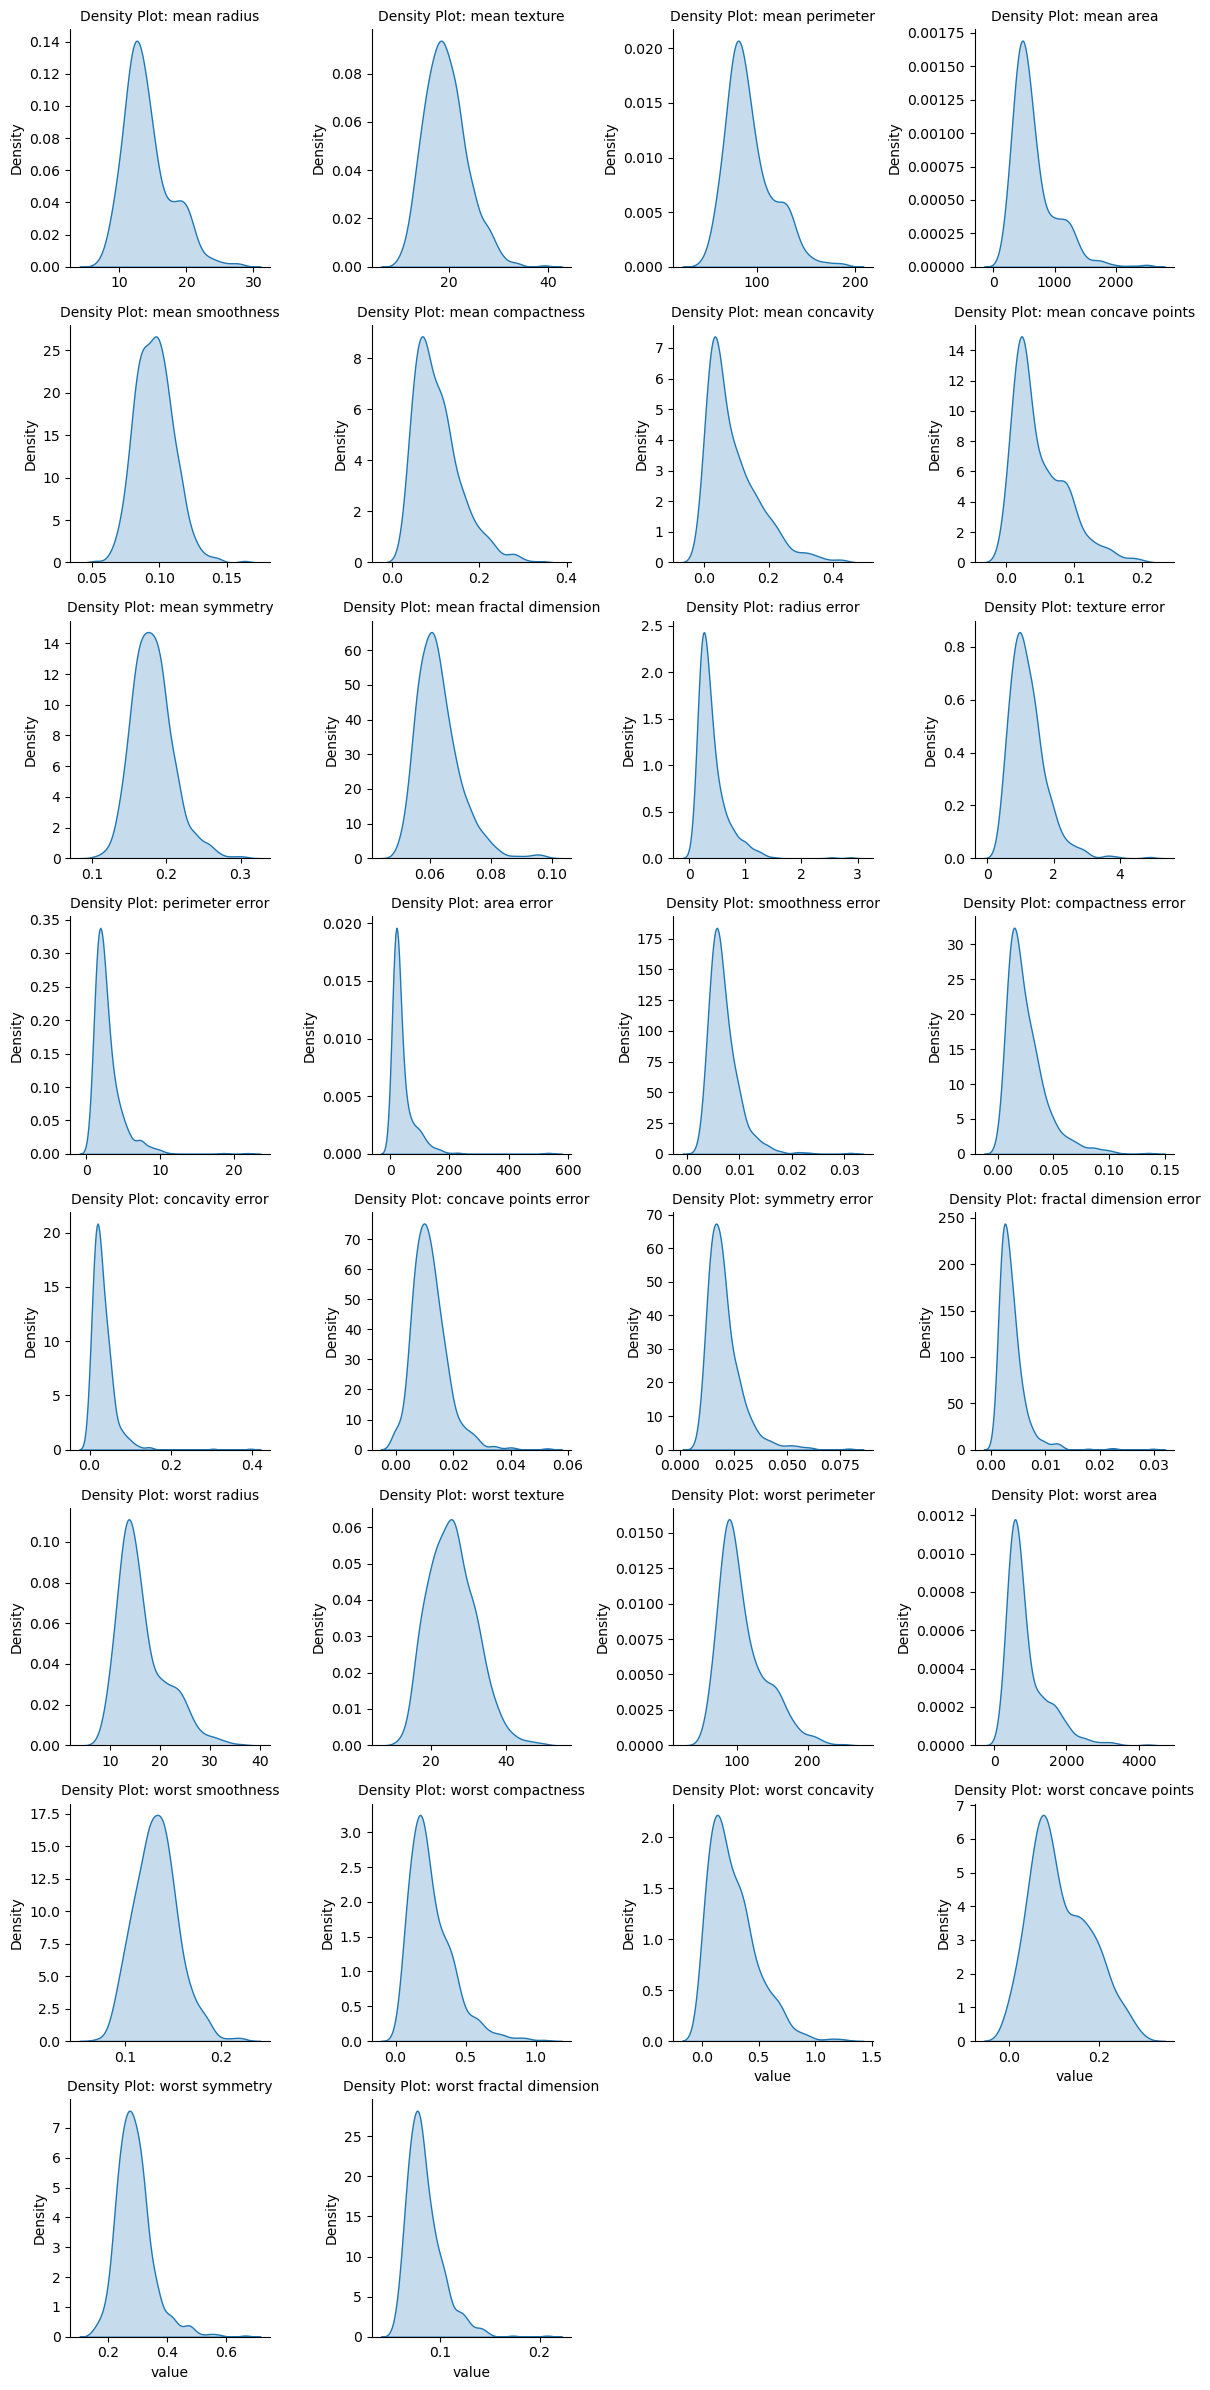

In [11]:
g = sns.FacetGrid(features.melt(), col='variable', col_wrap=4, sharex=False, sharey=False, height=3)
g.map(sns.kdeplot, 'value', fill=True)
g.set_titles('Density Plot: {col_name}')
plt.tight_layout()
plt.show()

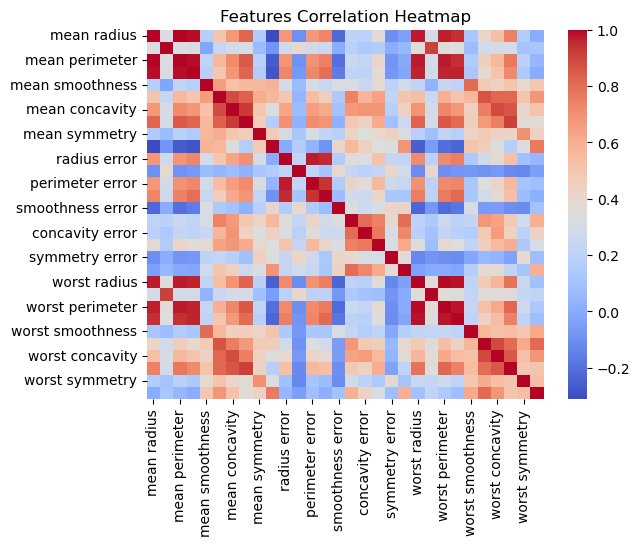

In [12]:
correlation_matrix = features.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Features Correlation Heatmap')
plt.show()

# Train test split + data standardization + shuffling
- Using min max scaler to standardize the data, as features were quite different distributed
- Test size = 0.25, as we do not have too much data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.25, random_state=36)
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=36)

# Building model with Keras 
- Input shape = 30, output shape = probability (value between 0 and 1)
- 7 layers, 8 neurons in the hidden layers, he_normal weight initializer, l2 + dropout regularization, final sigmoid activation

In [14]:
model_1 = keras.models.Sequential([ # more layers and regularization
    keras.layers.Flatten(input_shape=[30]),
    keras.layers.Dense(8, activation='relu', kernel_initializer = 'he_normal'),
    keras.layers.Dense(8, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(8, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)),
    keras.layers.Dropout(rate=0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
print(model_1.summary())
# As we are using dropout during training, there is a higher loss during training than during validation! The model is hence more robust during val than train due to dropout

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 8)                 248       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9

# Training the model
- Loss = Binary Cross Entropy
- Optimizer = Adam at 0.001 learning rate
- Metric = accuracy
- Batch size = 64
- Epochs = 300

In [16]:
model_1.compile(loss='BinaryCrossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001),  metrics = 'accuracy')
history = model_1.fit(X_train_shuffled, y_train_shuffled, batch_size = 64, epochs = 300, validation_data = (X_test, y_test))

Epoch 1/300


7/7 [==============================] - 2s 44ms/step - loss: 0.8760 - accuracy: 0.6056 - val_loss: 0.8670 - val_accuracy: 0.6503
Epoch 2/300
7/7 [==============================] - 0s 9ms/step - loss: 0.8665 - accuracy: 0.6127 - val_loss: 0.8584 - val_accuracy: 0.6503
Epoch 3/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8601 - accuracy: 0.6150 - val_loss: 0.8503 - val_accuracy: 0.6503
Epoch 4/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8549 - accuracy: 0.6244 - val_loss: 0.8426 - val_accuracy: 0.6503
Epoch 5/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8467 - accuracy: 0.6221 - val_loss: 0.8347 - val_accuracy: 0.6503
Epoch 6/300
7/7 [==============================] - 0s 10ms/step - loss: 0.8349 - accuracy: 0.6197 - val_loss: 0.8262 - val_accuracy: 0.6503
Epoch 7/300
7/7 [==============================] - 0s 8ms/step - loss: 0.8257 - accuracy: 0.6197 - val_loss: 0.8172 - val_accuracy: 0.6503
Epoch 8/300
7/7 [======

# Plotting loss and accuracy
- We can observe that the model correctly learns to classify between benign (0) and malign (1) after 300 epochs
- The validation loss is lower than the training loss, probably because we are using the dropout regularization technique in the training phase of the model, hence making more robust predictions during validation than training

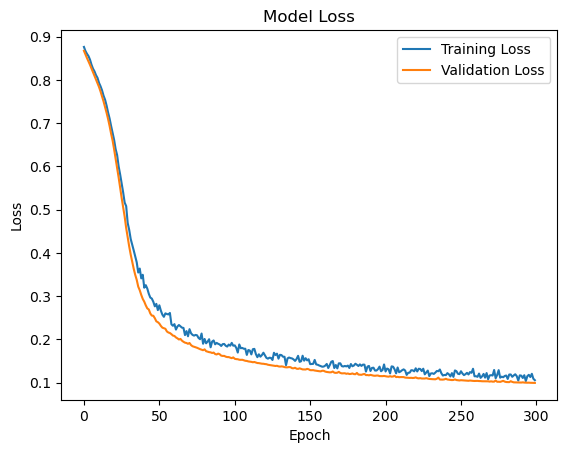

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

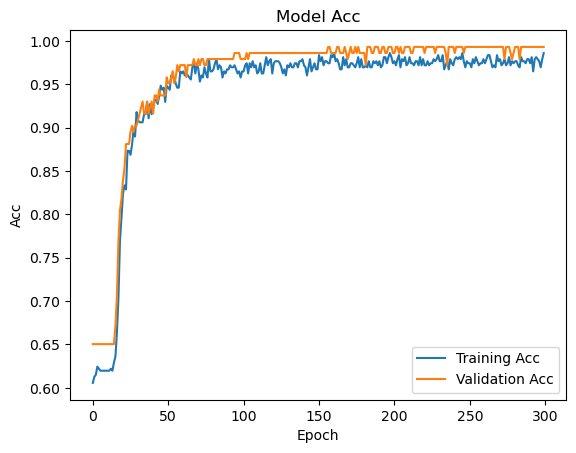

In [18]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Validation Acc')
plt.title('Model Acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.show()

# Visualizing some accuracy scores to better understand the model results and convergence

In [19]:
history.history['accuracy'][0:15]

[0.6056337952613831,
 0.6126760840415955,
 0.6150234937667847,
 0.6244131326675415,
 0.6220657229423523,
 0.6197183132171631,
 0.6197183132171631,
 0.6197183132171631,
 0.6197183132171631,
 0.6197183132171631,
 0.6197183132171631,
 0.6197183132171631,
 0.6220657229423523,
 0.6197183132171631,
 0.6291079521179199]

In [20]:
history.history['accuracy'][285:299]

[0.9765258431434631,
 0.9765258431434631,
 0.9741784334182739,
 0.9788732528686523,
 0.9788732528686523,
 0.9741784334182739,
 0.9812206625938416,
 0.9647887349128723,
 0.9788732528686523,
 0.9812206625938416,
 0.9788732528686523,
 0.9765258431434631,
 0.9694835543632507,
 0.9788732528686523]

# Comparing model's predictions with the test data for a visual understanding of the results

In [21]:
preds = model_1.predict(X_test)
y_pred_classes = (preds > 0.5).astype(int) # turning the predictions (probabilities) into classes (0 or 1) with a 0.5 threshold

5/5 [==============================] - 0s 690us/step


In [22]:
preds[0:10]

array([[9.9708289e-01],
       [9.9645704e-01],
       [9.7438216e-01],
       [9.9135417e-01],
       [9.9706531e-01],
       [3.8769981e-06],
       [5.1673942e-05],
       [9.9398357e-01],
       [9.7516638e-01],
       [9.9461716e-01]], dtype=float32)

In [23]:
y_pred_classes[0:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1]])

In [24]:
y_test[0:10]

,target
63,1
525,1
500,1
292,1
46,1
108,0
323,0
386,1
377,1
467,1


In [25]:
conf_matrix = confusion_matrix(y_test, y_pred_classes)

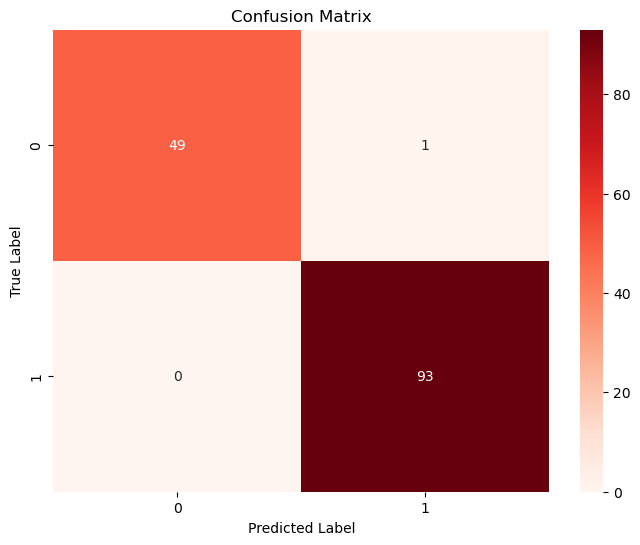

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()